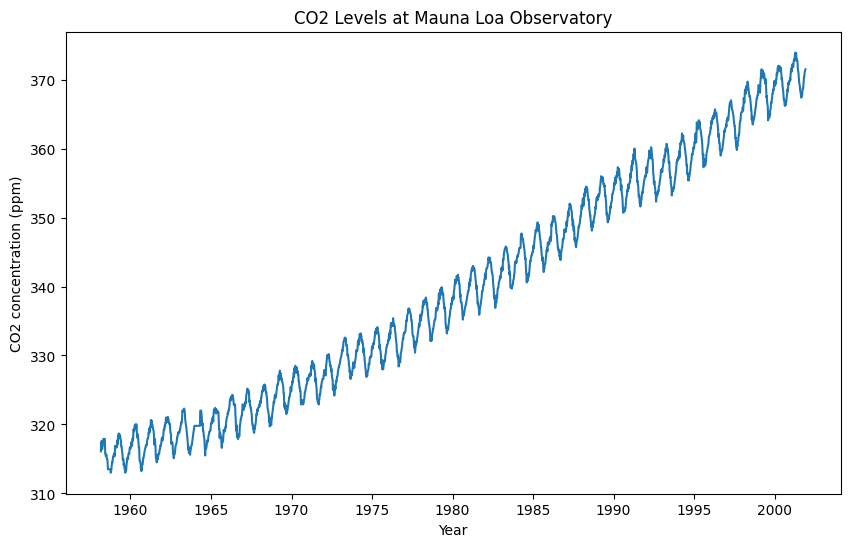

Epoch 1/10
1528/1528 - 17s - loss: 0.0036 - 17s/epoch - 11ms/step
Epoch 2/10
1528/1528 - 8s - loss: 7.3904e-05 - 8s/epoch - 5ms/step
Epoch 3/10
1528/1528 - 5s - loss: 7.7934e-05 - 5s/epoch - 3ms/step
Epoch 4/10
1528/1528 - 5s - loss: 7.5266e-05 - 5s/epoch - 3ms/step
Epoch 5/10
1528/1528 - 5s - loss: 7.5309e-05 - 5s/epoch - 4ms/step
Epoch 6/10
1528/1528 - 5s - loss: 7.7320e-05 - 5s/epoch - 3ms/step
Epoch 7/10
1528/1528 - 5s - loss: 7.5427e-05 - 5s/epoch - 3ms/step
Epoch 8/10
1528/1528 - 4s - loss: 7.7614e-05 - 4s/epoch - 3ms/step
Epoch 9/10
1528/1528 - 4s - loss: 7.6472e-05 - 4s/epoch - 3ms/step
Epoch 10/10
1528/1528 - 4s - loss: 7.6263e-05 - 4s/epoch - 3ms/step


In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import statsmodels.api as sm

# Load the dataset
data = sm.datasets.co2.load_pandas().data
data.fillna(method='ffill', inplace=True)  # Handling missing values
data['date'] = pd.date_range(start='1958-03', periods=len(data), freq='W-SAT')
data.set_index('date', inplace=True)

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.plot(data['co2'])
plt.title('CO2 Levels at Mauna Loa Observatory')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Year')
plt.show()

# Preprocess the data: Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['co2'].values.reshape(-1, 1))

# Define the create_dataset function
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  # Use last week's CO2 levels to predict the current week
X, y = create_dataset(scaled_data, look_back)

# Split the data into training and testing datasets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(train_X, train_y, epochs=10, batch_size=1, verbose=2)

In [22]:
train_X

array([[[0.05090312]],

       [[0.07060755]],

       [[0.07553366]],

       ...,

       [[0.62397373]],

       [[0.62233169]],

       [[0.60262726]]])

In [23]:
# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((train_predict - train_y) ** 2))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(np.mean((test_predict - test_y) ** 2))
print('Test Score: %.2f RMSE' % (testScore))

24/24 [==============================] - 0s 3ms/step
Train Score: 14.37 RMSE
Test Score: 9.04 RMSE


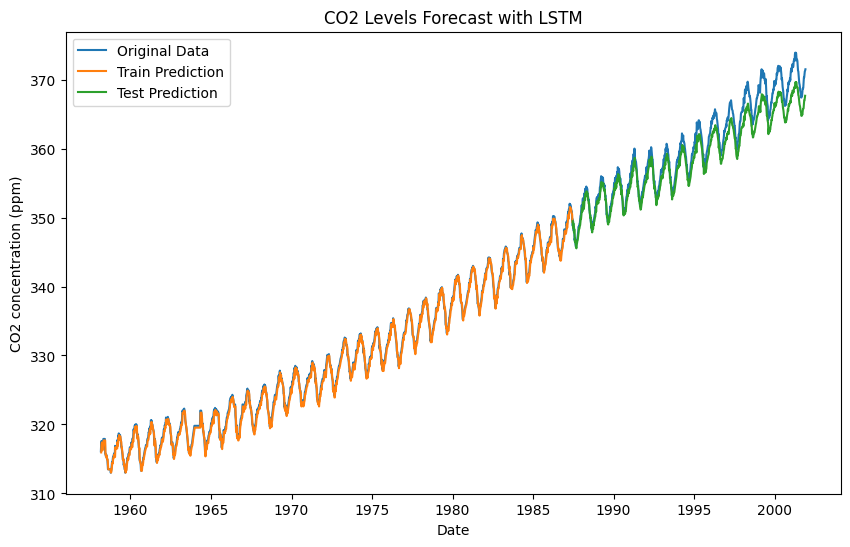

In [24]:
# Extract dates for the predictions
dates = data.index

plt.figure(figsize=(10, 6))

# Plot original dataset
plt.plot(dates, scaler.inverse_transform(scaled_data), label='Original Data')

# Plot training predictions
# Here we exclude the first `look_back` data points because the first prediction requires `look_back` points
train_dates = dates[look_back:train_size + look_back]
plt.plot(train_dates, train_predict, label='Train Prediction')

# Plot test predictions
# Adjusted test_dates to match the length of test_predict
test_dates = dates[train_size + look_back:train_size + look_back + len(test_predict)]
plt.plot(test_dates, test_predict, label='Test Prediction')

plt.title('CO2 Levels Forecast with LSTM')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Date')
plt.legend()
plt.show()



In [38]:
import plotly.express as px
num_future = 10
last_data = scaled_data[-look_back:]

future_predictions = []

for _ in range(num_future):
    x_input = last_data.reshape((1, 1, look_back))
    yhat = model.predict(x_input)
    future_predictions.append(yhat[0, 0])
    last_data = np.append(last_data, yhat)[1:]

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = pd.date_range(start=data.index[-1], periods=num_future + 1, freq='W-SAT')[1:]
df_future = pd.DataFrame([future_dates, future_predictions]).transpose()
df_future.columns = ["Date", "co2"]
df_future.set_index('Date', inplace=True)

df_future
df = pd.concat(df_future, data)

#px.line(x=data.index, y=data["co2"])


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 28ms/step


TypeError: concat() takes 1 positional argument but 2 were given